In [1]:
import os
from os.path import basename, dirname, join, exists
import glob
import sys
import time
from importlib import reload

import numpy as np
import numpy.ma as ma
import scipy.stats as stats
import pandas as pd
import geopandas as gpd

# 1d so the smoothing is specific to each realization
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import minimize


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines



In [2]:
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [3]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
    
git_dir = join(doc_dir,'GitHub','CosumnesRiverRecharge')
# dir of all gwfm data
gwfm_dir = join(dirname(doc_dir),'Box/research_cosumnes/GWFlowModel')


def add_path(fxn_dir):
    if fxn_dir not in sys.path:
        sys.path.append(fxn_dir)
        
flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)

import flopy 
import flopy.utils.binaryfile as bf


add_path(doc_dir+'/GitHub/CosumnesRiverRecharge/tprogs_utilities')
add_path(doc_dir+'/GitHub/CosumnesRiverRecharge/python_utilities')

In [4]:
from map_cln import gdf_bnds, pnt_2_tup, lab_pnt, plt_cln

In [5]:
# set box directory for output figures and data
box_dir = gwfm_dir+'/Levee_setback/levee_setback_distance_analysis/'

# tprogs_id = '' # original tprogs with conditioning data in output tsim
# tprogs_id = '_no_conditioning'
tprogs_id = '_no_cond_c3d'

proj_dir = join(box_dir, tprogs_id)

data_dir = join(proj_dir,'data_output/')
fig_dir = join(box_dir,'figures/')

chan_dir = box_dir+'channel_data/'
gis_dir = chan_dir+'GIS/'

In [6]:
method_dir = join(box_dir,'figures','methods') # directory for figures

In [7]:
nrow = 100
ncol = 230

In [8]:
dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_mean.tsv')


<>:1: DeprecationWarning: invalid escape sequence '\D'
<>:1: DeprecationWarning: invalid escape sequence '\D'
C:\Users\AndrewCalderwood\AppData\Local\Temp\ipykernel_45796\2785683405.py:1: DeprecationWarning: invalid escape sequence '\D'
  dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_mean.tsv')


In [9]:
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')

m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')

In [10]:
import h5py

f = h5py.File(join(chan_dir, 'setback_locs.hdf5'), "r")
local_str_setbacks = f['setbacks']['local'][:]
str_setbacks = f['setbacks']['regional'][:]

f.close()

# Map overview figure

In [ ]:
map_dir = join(gwfm_dir,'Mapping')
sfr_dir = join(gwfm_dir,'SFR_data')


In [ ]:
rivers = gpd.read_file(join(sfr_dir,"Sac_valley_rivers/Sac_valley_rivers.shp"))
rivers = rivers.to_crs('EPSG:32610')

mb_regional = gpd.read_file(join(gwfm_dir,"DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp"))
# mb = gpd.read_file(join(gwfm_dir,"DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp"))
rivers_clip = gpd.clip(rivers, mb_regional)

soam = gpd.read_file(join(map_dir,"so_am_subbasin/so_am_subbasin.shp"))
soam = soam.to_crs('EPSG:32610')
cos = gpd.read_file(join(map_dir,"cos_subbasin/cos_subbasin.shp"))
cos = cos.to_crs('EPSG:32610')

ca = gpd.read_file(join(map_dir,"ca_state_boundary/CA_State_TIGER2016.shp"))
ca = ca.to_crs('EPSG:32610')

In [ ]:
cr = rivers_clip[rivers_clip.GNIS_Name=='Cosumnes River']
mr = rivers_clip[rivers_clip.GNIS_Name=='Mokelumne River']

In [ ]:
transg = gpd.read_file(join(chan_dir,'GIS','transect_lines_3300.shp'))

In [20]:
grid_sfr = gpd.read_file(gwfm_dir+'/SFR_data/final_grid_sfr/grid_sfr.shp')


In [ ]:
sfr_buf = grid_sfr.buffer(3200).unary_union
sfr_buf = gpd.GeoDataFrame(pd.DataFrame([0]), geometry=[sfr_buf], crs=grid_sfr.crs)
sfr_buf = gpd.overlay(sfr_buf, m_domain)

In [ ]:
prms_gis = join(gwfm_dir,'PRMS','GIS')
ws_gdf = gpd.read_file(join(prms_gis, "NHD_H_18040013_HU8_Shape\Shape\WBDHU8.shp"))
ws_gdf=ws_gdf.to_crs(m_domain.crs)

In [ ]:
ws_gdf.area[0]/1000/1000

## References calcs
Information on pumping is taken from the South American Subbasin GSP.  

In [ ]:
long_late = 120


sasb_pump = 221618 # all uses pumping AF/year average 1995-2018
sasb_pump*= 43560*(0.3048**3) # convert to m3/year
sasb_pump /= 1E6 # convert to MCM
print('All pump %.2f' %sasb_pump)
print('%% of all pump %.2f' %(100*long_late/sasb_pump))

ag_pump = 96200 # avg ag pumping AF/year 2009-2018
ag_pump *= 43560*(0.3048**3)
ag_pump /= 1E6
print('Ag pump %.2f' %ag_pump)
print('%% of ag pump %.2f' %(100*long_late/ag_pump))


In [ ]:
120.8+21.5+495.9

In [ ]:
638/273.36

### Average climate
Rainfall Fiddletown (FDL) is in the upper watershed for rainfall.  
Ham Station (HMS) at 5500 ft and Podesta (PDT) at 7200 ft are in the upper watershed for snow depth.  
It is necessary to note the spatial coverage of snow is limited (only 20% of area).  

In [ ]:
cdec_dir = join(gwfm_dir, 'UZF_data', 'watershed_cdec_data')

In [ ]:
# average rainfall, inches
fdl = pd.read_excel(join(cdec_dir, 'FDL_rain.xlsx'), parse_dates=['DATE TIME'], na_values=['---'])
fdl = fdl.set_index('DATE TIME')
fdl.resample('AS-Oct').sum(numeric_only=True).mean()*2.54

In [ ]:
# average snow, inches
hms = pd.read_excel(join(cdec_dir, 'HMS_snow.xlsx'), parse_dates=['DATE TIME'], na_values=['---'])
hms = hms.set_index('DATE TIME')
hms.resample('AS-Oct').sum(numeric_only=True).mean()*2.54

# Regional map

In [ ]:


legend_elements = [
    Patch(facecolor='none', edgecolor='black', linestyle = '--', alpha=1., label='Watershed Extent'),
    Patch(facecolor='none', edgecolor='black',alpha=1., label='Model Extent'),
    Patch(facecolor='none', edgecolor='tab:blue', linestyle = '--',label='Levee Setback\nof 3200 m'),
    Line2D([0], [0],color='tab:blue',label='Cosumnes River'),
    Line2D([0], [0],color='black',label='Stream Channel\nCross-sections'),
#     Line2D([0], [0], marker='.', linestyle='', color='blue', label='Monitoring Well'),
]


In [ ]:
# not useful, only limited levees on American R.
# levees = gpd.read_file(join(map_dir, 'Department_of_Water_Resources_Assets','Levees.shp')).to_crs(m_domain.crs)

In [ ]:
# fig,ax = plt.subplots()
# # levees.plot(ax=ax)
# m_domain.plot(ax=ax, edgecolor='black',color='none')
# transg.plot(ax=ax)

In [ ]:

def ref_map(axins):
    ca.plot(ax = axins,alpha = 0.2, edgecolor='black')
    axins.annotate(text='California', xy=lab_pnt(ca), 
                xytext = (6,-30), textcoords = 'offset points',
                bbox=dict(boxstyle="square,pad=0.3", fc="lightgrey", ec="black", lw=2), zorder=1)
    # second one is smaller inset
    axins.tick_params(labelleft=False, labelbottom=False, left = False, bottom = False)

    ws_gdf.plot(color='none',ax=axins, linestyle='--')
    m_domain.plot(color="none",edgecolor='black',ax=axins)
    return axins


def main_map(ax):
    ## main figure ##
    plt_bnds = gdf_bnds(m_domain,ax=ax, buf=200)

    ws_gdf.plot(color='none',ax=ax, linestyle='--')
    m_domain.plot(color="none",edgecolor='black',ax=ax)

    cr.plot(ax=ax, color='tab:blue')
    # mr.plot(ax=ax, color='tab:blue')
    sfr_buf.plot(ax=ax, color='none',edgecolor='tab:blue', linestyle='--')
    transg.plot(ax=ax, color='black', linewidth=1)

    ctx.add_basemap(ax=ax, source = ctx.providers.Esri.WorldImagery, attribution=False, attribution_size=6,
                    crs = 'epsg:26910', alpha=0.7)

    x, y, arrow_length = 0.7, 0.15, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='center', va='center', fontsize=20, 
                xycoords=ax.transAxes)

    fontprops = fm.FontProperties(size=18)
    scalebar = AnchoredSizeBar(ax.transData,
                               10000, '10 km', 'lower right', pad=0.3, sep=2,color='black',
                               frameon=False, size_vertical=5E2, fontproperties=fontprops)
    ax.add_artist(scalebar)
    ax.tick_params(labelleft=False, labelbottom=False, left = False, bottom = False)

    # ax.legend(handles=legend_elements, loc='upper left')
    ax.legend(handles=legend_elements, loc=(0.6,0.2))


## inset figure ##
# fig, axins =plt.subplots(dpi=300)

# axins = ref_map(axins)
# # first one is CA map
# ax = inset_axes(axins, width="100%", height="100%", bbox_to_anchor=(0.8, -.1, 1.3, 1.3),
#                   bbox_transform=axins.transAxes, loc=2)

# main_map(ax=ax)
    
# mark_inset(axins, ax, loc1=2, loc2=3, fc="none", ec="black")

# plt.savefig(join(method_dir, 'regional_domain_map.png'), bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots(figsize=(6.5, 6.5), dpi=300)

main_map(ax=ax)

axins = inset_axes(ax, width="35%", height="35%", 
                   loc='upper left',
                   bbox_to_anchor=(-.01, .01, 1, 1),
                  bbox_transform=ax.transAxes, 
                   # loc=2
                  )
ref_map(axins)

plt.savefig(join(fig_dir, 'regional_domain_map.png'), bbox_inches='tight')


In [ ]:
# # save shapefiles to a directory for Helen to use for mapping
# gis_map = join(box_dir, 'gis_map_overview')
# ca.to_crs('epsg:4269').to_file(join(gis_map, 'CA_boundary.shp'))
# ws_gdf.to_file(join(gis_map, 'HUC8_watershed_boundary.shp'))
# m_domain.to_file(join(gis_map, 'model_domain_boundary.shp'))
# cr.to_file(join(gis_map, 'cosumnes_river_stream_line.shp'))
# transg.to_file(join(gis_map, 'channel_transect_lines.shp'))

# sfr_buf_all = pd.DataFrame()
# for d in np.arange(200,3400, 200):
#     sfr_buf = grid_sfr.buffer(d).unary_union
#     sfr_buf = gpd.GeoDataFrame(pd.DataFrame([0]), geometry=[sfr_buf], crs=grid_sfr.crs)
#     sfr_buf = gpd.overlay(sfr_buf, m_domain)
#     sfr_buf['setback_m'] = d
#     sfr_buf_all = pd.concat((sfr_buf_all, sfr_buf))
# # save files
# sfr_buf_all.drop(columns=[0]).to_file(join(gis_map, 'sfr_grid_setback_distances.shp'))
# grid_sfr.to_file(join(gis_map, 'sfr_grid_cells.shp'))


In [ ]:
# XS 23, 24 (1-based) seem to be where the XS might be an issue

# Flood type and cross-section figure

In [ ]:
setbacks = np.arange(0, 3400,200)
# original XS data
xs_all_df = pd.read_csv(chan_dir+'Elevation_by_XS_number_meters.csv',index_col='dist_from_center_m')
# smoothed XS data used for setback analysis
xs_levee_smooth = pd.read_csv(chan_dir+'xs_levee_smooth.csv', index_col='dist_from_center_m')
# adjust distance so channel is 0
# xs_levee_smooth.index -= 3300
# xs_all_df.index -= 3300

num_segs = xs_all_df.shape[1]

# load array identifying row,col to XS id (1,28)
xs_arr = np.loadtxt(chan_dir+'XS_num_grid_reference.tsv')

# load flood typology characteristics (based on daily data 1908 - 2014) - median values 
#"cms_pk" for peak discharge, "pk_loc" for time to peak, and "log_no_d" for duration
flood_type = pd.read_csv(join(box_dir, 'whipple_grp6_w97ftmedians.csv'),index_col='Group.1')


In [ ]:
def map_lab(gdf, text, ax, offset = (0,0)):
    xy = gdf.geometry.unary_union.centroid.coords[0]
    ax.annotate(text=text, xy=xy, ha='center', va = 'bottom', xytext = offset, textcoords='offset points',
                arrowprops = {'shrinkA':1,'arrowstyle':'simple', 'color':'black'},
                bbox=dict(boxstyle="square,pad=0.3", fc="lightgrey", ec="black", lw=2))
# def plt_lab(xy, text, ax, offset = (0,0)):
#     ax.annotate(text=text, xy=xy, ha='center', va = 'bottom', xytext = offset, textcoords=('data', 'offset points'),
#                 arrowprops = {'shrinkA':1, 'arrowstyle':'simple', 'color':'black'},
#                 bbox=dict(boxstyle="square,pad=0.3", fc="lightgrey", ec="black", lw=1))
def plt_lab(xy, text, ax, offset = (0,0)):
    ax.annotate(text=text, xy=xy, ha='center', va = 'bottom', xytext = offset, textcoords=('data', 'offset points'),
                arrowprops = dict(headwidth=3, headlength=2, width=0.5, color='black'),
                bbox=dict(boxstyle="square,pad=0.3", fc="lightgrey", ec="black", lw=1))

In [ ]:
def plt_hydrograph(ft, ax):
    # typical winter baseflow, peak flow, peak location, total time (days)
    # flow of 23 m3/s listed by Whipple as floodplain cutoff
    q_base = 23
    q_peak = flood_type.loc[ft,'cms_pk']
    # total duration in days 
    T = int(10**flood_type.loc[ft,'log_no_d'])
    p_l = flood_type.loc[ft,'pk_loc']
    tp = int(p_l*T)
    q_rise = np.linspace(q_base, q_peak, tp)
    q_fall = np.linspace(q_peak, q_base, (T-tp+1))
    q_in = np.append(q_rise, q_fall[1:])
    ax.plot(q_in)
    # annotation with type label
    plt_lab((tp*3, q_in[tp*3]), flood_type.loc[ft,'Typology'], ax, offset=(50, -0.05*q_peak)) 

    ax.vlines(x = tp-1, ymin=q_base, ymax = q_peak, linestyle='--',color='grey')
    ax.set_xlabel('Days')
    ax.set_ylabel('Flow ($m^3/s$)')
    return(q_in)


## XS figure
2 subplots, the one on the right shows an example model XS with the original data and rolling average of elevation, vertical lines for each setback distance, elevations of flood depth for each corresponding peak flow. The left plot will show the triangular hydrograph for the three plots, but plot with curved lines rather than straight to show a more realistic hydrograph. 

In [ ]:
from muskingum_recharge import min_Q, mannings, calc_depth_arr, gridded_interpolation, xs_setback, mannings_v


In [ ]:
# rating curves for each segment and setback
xs_flow_all = pd.read_csv(join(chan_dir,'all_xs_50pt_rating_curves.csv'))
# xs_flow_all = pd.read_csv(join(chan_dir,'all_xs_smooth_50pt_rating_curves.csv'))

In [ ]:
def depth_match(seg_flow, flow):
    """ Given a XS (nseg, setback) return the expected depth (m) given a flow (cms)"""
    # find flows above and below the input flow
    flow_diff = (seg_flow.flow_cms-flow)
    f_high = flow_diff[flow_diff>0].argsort().index[0]
    f_low = flow_diff[flow_diff<0].argsort().index[-1]
    match_d = seg_flow.loc[[f_low, f_high]].sort_values('flow_cms')
    # linearly interpolate to calculate exact depth
    flow_slope = (match_d.iloc[1].flow_cms-match_d.iloc[0].flow_cms)/(match_d.iloc[1].depth_m-match_d.iloc[0].depth_m)
    out_depth = match_d.iloc[0].depth_m + (flow-match_d.iloc[0].flow_cms)/flow_slope
    return(out_depth)

In [ ]:
def clean_xlabel(ax_n):
    ax_n.set_xticks(np.arange(-3300,3500,200), minor=True)
    xleft = np.arange(-3300,-800,800)
    xright = np.arange(900,3500,800)
    ax_n.set_xticks(np.append(xleft, xright), np.append(xleft+100, xright-100))
    # ax_n.set_ylim(xs_all_df.iloc[:,nseg].min()*0.8, xs_all_df.iloc[:,nseg].max()*1.2)


In [ ]:
xs_all_plt = xs_all_df.copy()
# xs_all_plt = xs_levee_smooth.copy()

nseg = int(xs_all_plt.shape[1]/2)
# nseg = 24 # shows well had different flood depths inundate area
# nseg= 20 # shows flow filling side channels and some floodplain
nseg = 22

fig,ax = plt.subplots(2,1, figsize=(6.5,6), dpi=300)
ax_n = ax[1]

setback = 3200
seg_flow = xs_flow_all[(xs_flow_all.nseg==nseg)&(xs_flow_all.setback==setback)]
   
## Plot Example Cross-section ##
xs_all_df.iloc[:,nseg].plot(ax=ax_n, label='Cross Section', color='black')
# plot was getting too messy with the original and filled XS
# xs_levee_smooth.iloc[:,nseg].plot(ax=ax_n, label='Cross Section',  color='black')
# plot streambed thickness
# ax[1].fill_between(xs_levee_smooth.index, xs_levee_smooth.iloc[:,nseg], 
#                    xs_levee_smooth.iloc[:,nseg]-2, color='brown', alpha=0.5, label='Streambed Thickness')

## Plot hydrographs ##
for ft in [1,2,3]:
    q_in = plt_hydrograph(ft, ax[0])
    # add depth to XS plot
    d = depth_match(seg_flow, flood_type.loc[ft,'cms_pk'])
    fld_elev = (xs_all_plt.iloc[:,nseg].min()+d)*np.ones(xs_levee_smooth.shape[0])
    fld_elev[fld_elev<xs_all_plt.iloc[:,nseg]] = np.nan
    plt.plot(xs_all_plt.index, fld_elev, label=flood_type.loc[ft,'Typology']) # color='blue'
    # wetted perimeter
    wp = xs_all_plt.iloc[:,nseg].copy()
    wp[wp>np.nanmean(fld_elev)] = np.nan
    plt.plot(xs_all_plt.index, wp, color='brown')

# plt.plot(xs_all_plt.index, fld_elev, label='Flood Elevation', color='tab:green') #color='blue', 
plt.plot(xs_all_plt.index, wp, color='brown', label='Wetted Perimeter')

ax_n.set_xlabel('Distance from river center (m)')
ax_n.set_ylabel('Elevation (m AMSL)')

plt.legend()

clean_xlabel(ax_n)
# ax_n.set_xticks(np.arange(-3300,3500,200), minor=True)
# xleft = np.arange(-3300,-800,800)
# xright = np.arange(900,3500,800)
# ax_n.set_xticks(np.append(xleft, xright), np.append(xleft+100, xright-100))
ax_n.set_ylim(xs_all_df.iloc[:,nseg].min()*0.8, xs_all_df.iloc[:,nseg].max()*1.2)

# plot vertical lines at each setback
for ns, s in enumerate(setbacks[::4]):
    ax_n.axvline(s+100, linewidth=0.1)
    ax_n.axvline(s-3300, linewidth=0.1)
    
fig.tight_layout()

plt.savefig(join(fig_dir, 'flood_types_channel_cross_section.png'), bbox_inches='tight')


In [ ]:
ft = 1

ny = 4
nx = int(len(setbacks[1:])/ny)
fig,axes =plt.subplots(nx,ny, figsize=(8,8), sharex=True, sharey=True)
# setback = 3200
for n, setback in enumerate(setbacks[1:]):
# for n, setback in enumerate([200]):
    ax = axes[int(n/ny), n%ny]
    seg_flow = xs_flow_all[(xs_flow_all.nseg==nseg)&(xs_flow_all.setback==setback)]
     
    # xs_elevs = xs_all_df.loc[-setback-100:setback+100, str(nseg)]
    xs_elevs = xs_setback(xs_all_df.iloc[:, nseg].copy(), setback, levee_ft=30)
    xs_elevs.plot(ax=ax, label='Cross Section', color='black')
    
    # add depth to XS plot
    d = depth_match(seg_flow, flood_type.loc[ft,'cms_pk'])
    fld_elev = (xs_elevs.min()+d)*np.ones(xs_elevs.shape[0])
    fld_elev[fld_elev<xs_elevs] = np.nan
    ax.plot(xs_elevs.index, fld_elev, label=flood_type.loc[ft,'Typology']) # color='blue'
    ax.set_xlabel(None)

for n in np.arange(0,ny):
    ax = axes[-1,n]
    clean_xlabel(ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
fig.supylabel('Elevation (m)')
fig.supxlabel('Distance from channel (m)')
fig.tight_layout(h_pad=0.1, w_pad=-0.1)
ax.set_ylim(xs_all_df.iloc[:,nseg].min()*0.8, xs_all_df.iloc[:,nseg].max()*1.2);



# Demonstration of overlay of HCP and flood depth to get recharge

In [11]:
colors = ['lightgray', 'blue']
cm_scale = [0, 1]
cmap=mpl.colors.ListedColormap(colors)
norm=mpl.colors.BoundaryNorm(cm_scale, len(colors))


In [12]:
flow_percentile=6
hf_tot_in =  np.loadtxt(data_dir+'surface_highflow_by_realization_'+str(flow_percentile)+'.tsv',delimiter = '\t')
hf_tot = np.reshape(hf_tot_in, (100, nrow, ncol))
# hf_tot

In [13]:
# tprogs near surface data
soil_thick=2
# fn = chan_dir+'/tprogs_geomK_'+str(soil_thick)+'m_depth.tsv' # old version with linear dem and old function for sampling tprogs
fn = chan_dir+'/tprogs_geomK_'+str(soil_thick)+'m_depth_dem_mean.tsv'
# units of m/day
soil_K_out = np.loadtxt(fn, delimiter='\t')
soil_K = np.reshape(soil_K_out, (100, nrow, ncol))
# convert soil conductivity from m/d to m/s and apply vertical anisotropy factor
vani = 100
soil_K = (soil_K/vani)

In [14]:
ft_in = 2
region='regional'
# spatial view
f = h5py.File(join(data_dir,'hdf5', 'all_recharge_'+region+'_type'+str(ft_in)+'.hdf5'), "r")
rch_hf_all = f['array']['all'][:]
f.close()
f = h5py.File(join(data_dir,'hdf5', 'depth_avg_arr'+region+'_type'+str(ft_in)+'.hdf5'), "r")
d_all = f['array']['all'][:]
f.close()


In [15]:
t= 5
s = 6

In [21]:

def sfr_setback(grid_sfr, grid_p, s):
    setback = s*200

    # grid_sfr = gpd.read_file(gwfm_dir+'/SFR_data/final_grid_sfr/grid_sfr.shp')
    sfr_union = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_sfr.unary_union], crs=grid_sfr.crs)
    sfr_union.geometry = sfr_union.buffer(setback).exterior
    # grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
    
    setback_grid = gpd.sjoin(sfr_union, grid_p, how='left')
    setback_outer = np.zeros((nrow,ncol))
    setback_outer[setback_grid.row-1, setback_grid.column-1] = 1
    setback_outer = ma.masked_where(setback_outer==0,setback_outer)
    return(setback_outer)

setback_outer = sfr_setback(grid_sfr, grid_p, s)

In [22]:
title = ['High Conductivity Pathways', 'Floodplain Inundation','Floodplain Recharge']
title = ['(A)', '(B)','(C)']
def floodplain_annotate(ax, setback_outer, title=['(A)', '(B)','(C)']):

    for n in np.arange(0,len(title)):
        ax_n = ax[n]
        ax_n.imshow(setback_outer, cmap='gray') # works when dpi=600
        ax_n.plot(grid_sfr.column-1, grid_sfr.row-1, color='black', linewidth=0.5, linestyle='-.')
        ax_n.annotate(text = title[n], xy=(0.1,0.8), xycoords='axes fraction',
                      bbox={'facecolor': 'lightgray', 'alpha': 0.9, 'pad': 2})


In [17]:
## plot for the methods to show overlay of HCP, flood depth to recharge

# fig, ax = plt.subplots(3,1, dpi=600,figsize=(8,6), sharex=True)
def ex_depth_rch(t,s, fig,ax, cbar_log=True):
    plt.setp(ax, xticks=[], yticks=[])
    
    ## plot HCPs
    ax_n = ax[0]
    # im = ax_n.imshow(hf_tot[t],cmap=cmap)
    # # color bar on all rows, with two discrete labels
    # cbar=plt.colorbar(mappable = im, ax=ax_n,  ticks = [0.25,.75], shrink= 0.6)
    # cbar.ax.set_yticklabels(['Low K', 'HCP'])
    im_K = ax_n.imshow(soil_K[t], 
                     norm= mpl.colors.LogNorm(),
                     cmap='viridis', alpha=0.7,
                    )
    if cbar_log:
        plt.colorbar(im, ax=ax_n, orientation='vertical', label='Vertical Conductivity (m/d)',
                     shrink=0.6,location='right')
    
    ## plot flood depth
    ax_n = ax[1]
    nf = 2 
    d_plt = np.ma.masked_invalid(d_all[t, s])
    # vmax for depth/recharge are manually specified
    im_d = ax_n.imshow(d_plt, vmax=2.5,
                     # norm = mpl.colors.LogNorm(vmin = 1E-2, vmax = np.nanmax(d_plt)),
                     cmap= 'cool',#'viridis_r', 
                     zorder=1
                    )
    if cbar_log:
        plt.colorbar(im, ax=ax_n, orientation='vertical', label='Depth (m)', shrink=0.6,location='right')
    ## plot recharge
    ax_n = ax[2]
    temp = rch_hf_all[t,s]*1E-6
    im_rch = ax_n.imshow(np.ma.masked_where(temp==0, temp), vmax=3.5,
                     cmap = 'plasma' ) #'YlOrRd': hard to see yellow, # plasma was nice, magma/inferno are intense with black
    if cbar_log:
        plt.colorbar(im, ax=ax_n, orientation='vertical', label='Total Recharge (MCM)', 
                     shrink=0.6,location='right')
    

    # fig.tight_layout(h_pad=-.3) #pad=0.4, w_pad=0.5,
    return(im_K, im_d, im_rch)
    # plt.savefig(join(fig_dir, 'example_vka_depth_recharge'+str(s*200)+'.png'), bbox_inches='tight')

In [18]:
def ex_cbar(fig,ax, im_K, im_d, im_rch):
    cbar0 = ax[0].ravel()
    cbar1 = ax[1].ravel()
    cbar2 = ax[2].ravel()
    shrink=0.6
    plt.colorbar(im_K, ax=cbar0, orientation='vertical', label='Vertical Conductivity\n(m/d)', 
                 shrink=shrink,location='right')
    plt.colorbar(im_d, ax=cbar1, orientation='vertical', label='Depth (m)', shrink=shrink,location='right')
    plt.colorbar(im_rch, ax=cbar2, orientation='vertical', label='Total Recharge (MCM)', 
                         shrink=shrink,location='right')
    

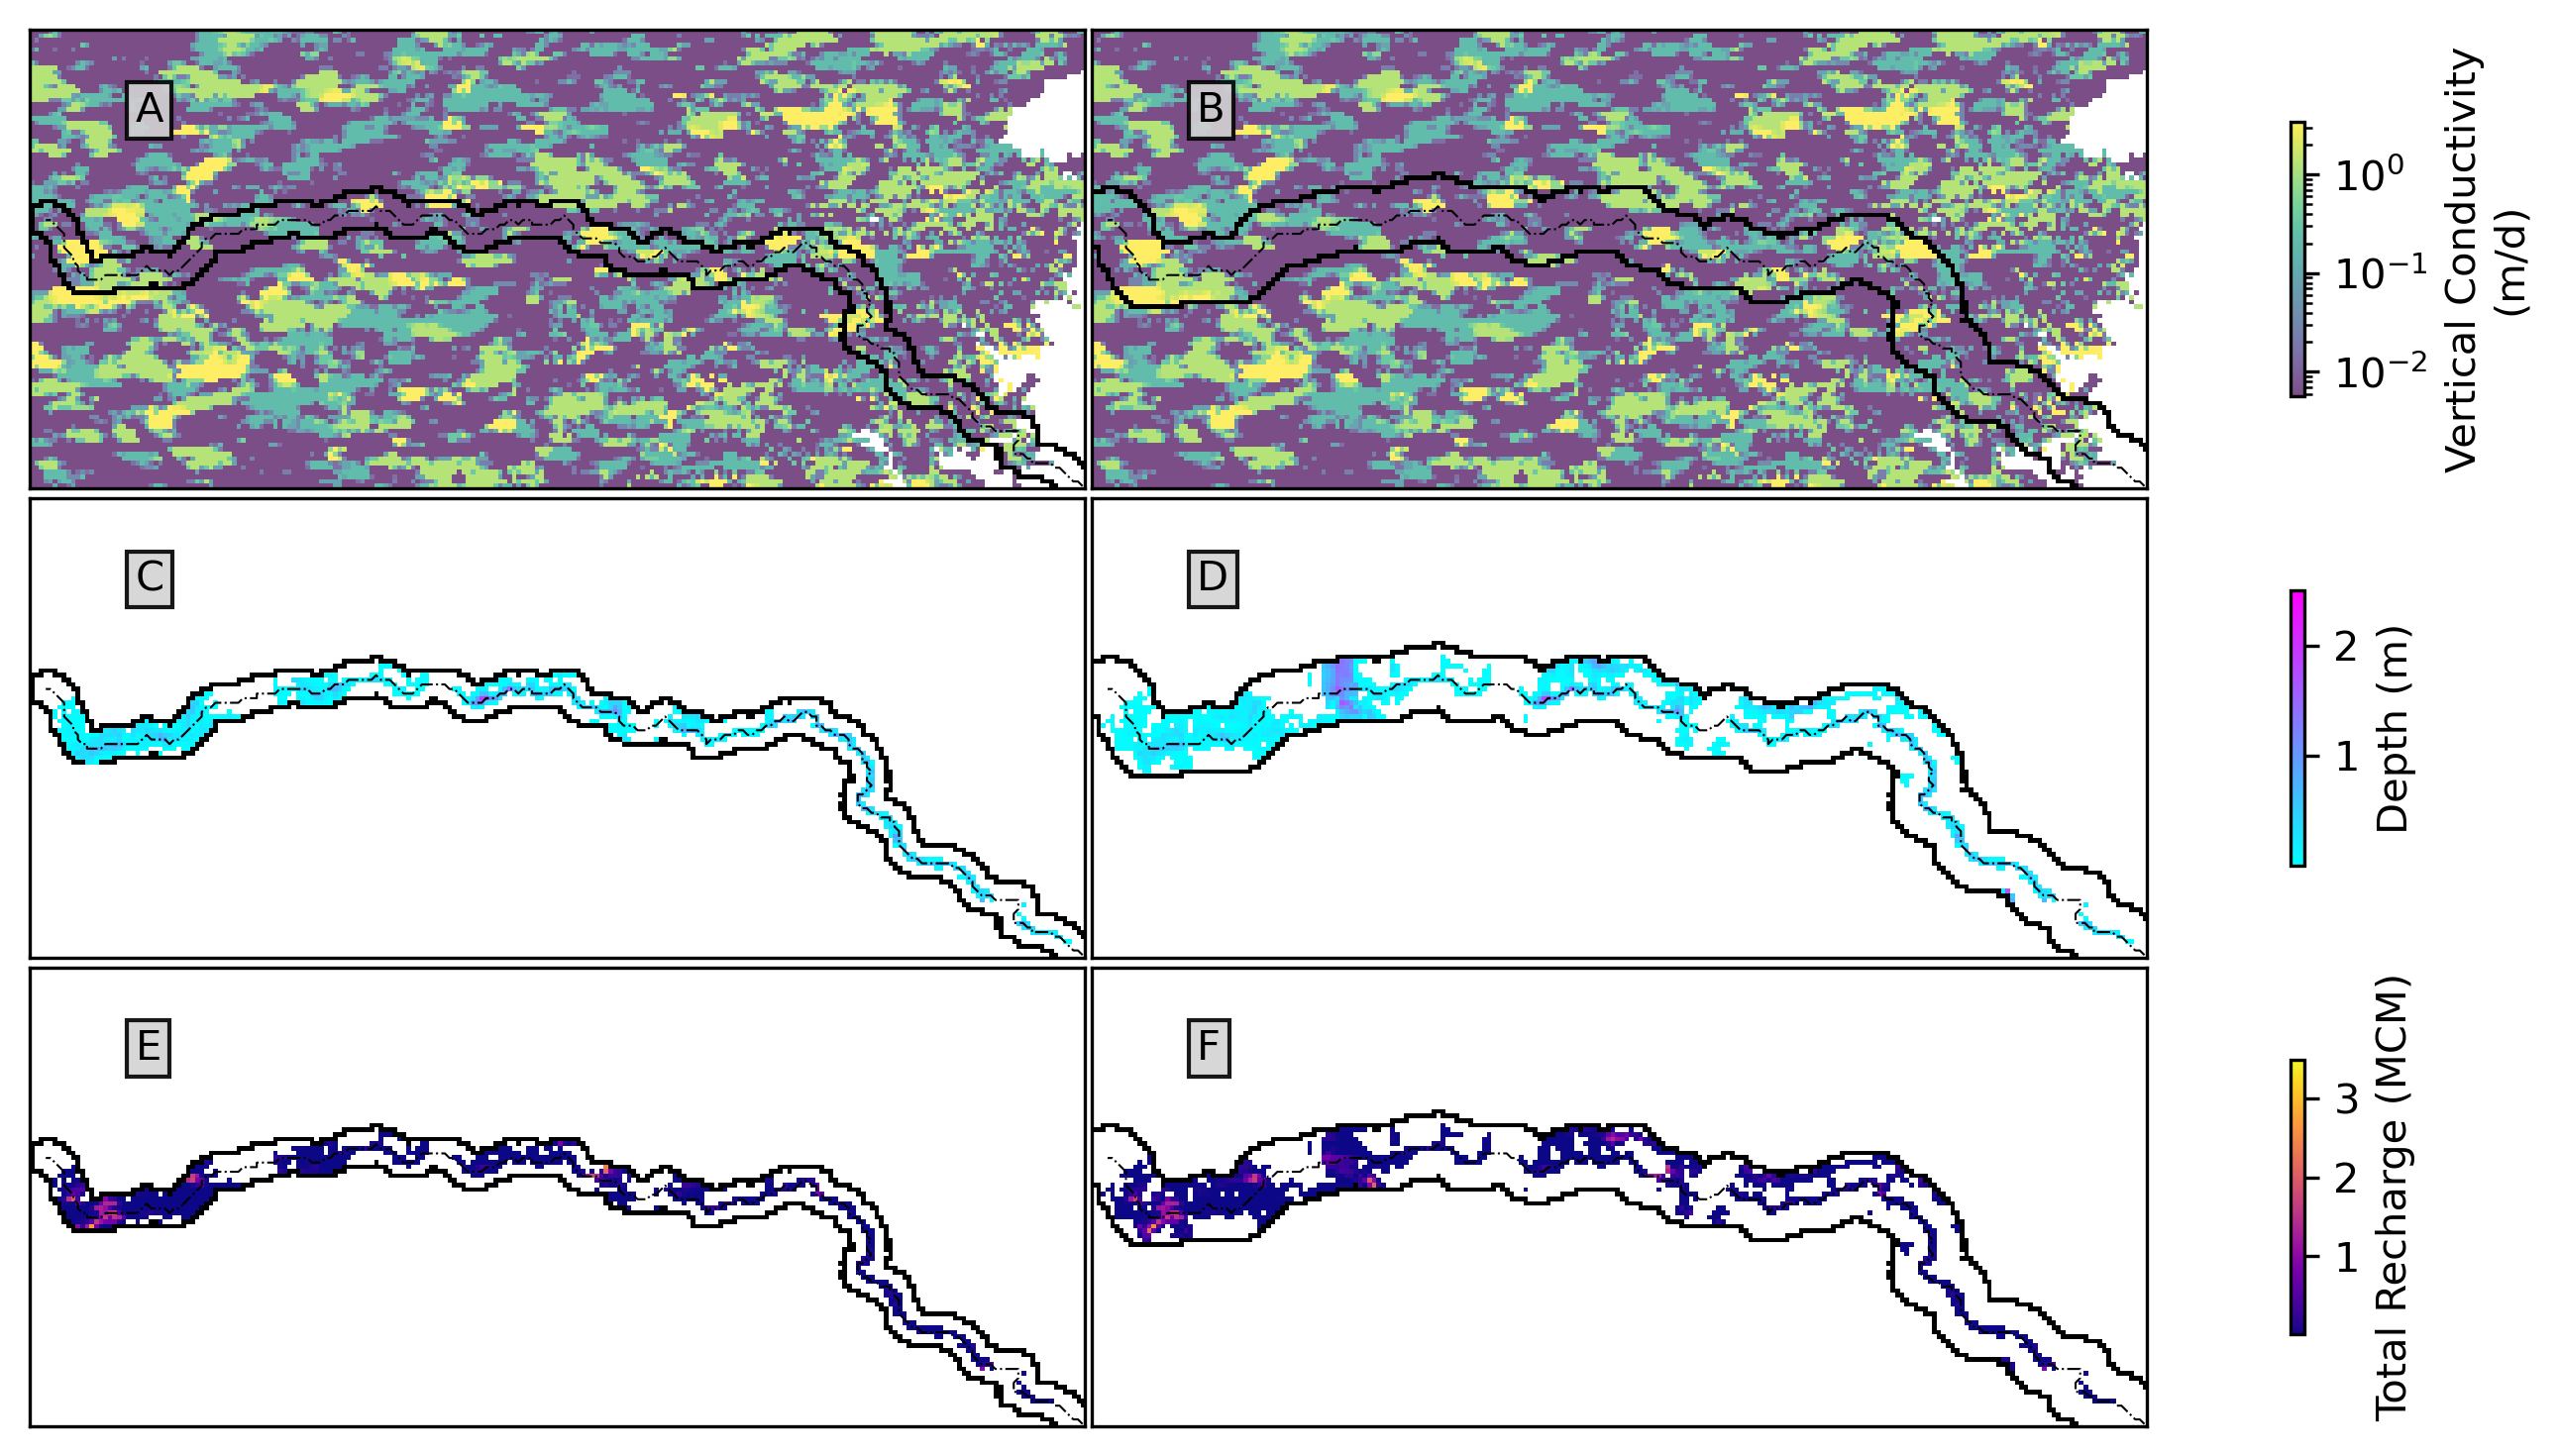

In [40]:
# took manual adjustments to find 11, 6.5 with h_pad-1 to work
fig,ax = plt.subplots(3,2, dpi=300,figsize=(10, 5), sharex=True,
                     )
im_K, im_d, im_rch = ex_depth_rch(t, 3, fig,ax[:,0], cbar_log=False)
setback_outer = sfr_setback(grid_sfr, grid_p, 3)
floodplain_annotate(ax[:,0], setback_outer, title=['A', 'C','E'])
    
im_K, im_d, im_rch = ex_depth_rch(t, 6, fig,ax[:,1], cbar_log=False)
setback_outer = sfr_setback(grid_sfr, grid_p, 6)
floodplain_annotate(ax[:,1], setback_outer, title=['B', 'D','F'])

# fig.tight_layout(h_pad=-1.5, w_pad=1)
fig.tight_layout(h_pad=.25) #pad=0.4, w_pad=0.5,
# fig.tight_layout(h_pad=0, w_pad=0)
ex_cbar(fig,ax, im_K, im_d, im_rch )

# fig.tight_layout(h_pad=-.3) #pad=0.4, w_pad=0.5,

plt.savefig(join(fig_dir, 'example_vka_depth_recharge_side_by_side_alt.tif'), bbox_inches='tight')

**Summary values** (from Helen)
- state total HCP area, flooded HCP area, state how much recharge occurred under the large and long flood,
    - try express as fractions in terms of %of total area
- Also calculate the recharge in background area and compare it total HCP recharge and total non HCP recharge   

In [ ]:
def rch_summary(t,s):
    # area of HCP in setback
    hf_sum = (hf_tot[t]*str_setbacks[s]).sum()
    s_area = str_setbacks[s].sum()
    # area of HCP inundated divided by HCP area in setback
    hf_frac = (hf_tot[t]*(d_all[t,s]>=0.1)).sum()/hf_sum
    # area of HCP inundated divided by total setback area
    hf_frac = (hf_tot[t]*(d_all[t,s]>=0.1)).sum()/s_area
    print('Setback distance of %.i m:' %(s*200))
    print('HCP area as fraction of setback area %.2f%%' %(hf_sum*100/s_area))
    print('Flooded HCP area as fraction of total HCP %.2f%%' %(hf_frac*100))
    
    rch_sum = (rch_hf_all[t,s]*1E-6).sum()
    print('Total recharge %.2f MCM' %rch_sum)
    
    rch_hcp = (rch_hf_all[t,s]*1E-6*hf_tot[t]).sum()
    print('Total HCP recharge %.2f MCM' %rch_hcp, 'and fraction is %.1f %%' %(rch_hcp*100/rch_sum))
    rch_non_hcp = (rch_hf_all[t,s]*1E-6*(~hf_tot[t].astype(bool))).sum()
    print('Total non HCP recharge %.2f MCM' %rch_non_hcp)

In [ ]:
rch_summary(t,3)


In [ ]:
rch_summary(t,6)

In [ ]:
rch_summary(t,7)

# Geology figure

3d figure of geology to show the 4 different facies (mud, sandy mud, sand and gravel), with data above the DEM cropped and the Cosumnes River highlighted in blue. Secondary figure showing the facies categorized as coarse vs fine and zoomed in to a smaller area to show a connected body travels vertically, ideally with an example of a coarse body that is isolated so is removed. 

I checked the imapct Connec3D without coarse above land surface and the percentage of CCO kept only went down from 97.6 to 96.1 so there is not a significant impact. That just means there is a lot of connectivity in the subsurface and we might need to use the volumetric filtering to create a cleaner plot.

In [ ]:
import tprogs_cleaning as tc
import pyvista as pv


In [ ]:

# directory with a few CCO files for method's figure plotting
cco_dir = join(proj_dir,'CCO_for_plots')

In [ ]:

tprogs_id = '_no_conditioning'
mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final' + tprogs_id+'/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')
# tprogs_files


In [ ]:
arr_dim = (320, 100, 230)

In [ ]:
t = 0
tprogs_line = np.loadtxt(tprogs_files[t])
# convert any negatives representing input data to same value
tprogs_arr = np.abs(np.reshape(tprogs_line, (320, 100,230)))
conn_arr = np.zeros((320, 100,230))
# new array where sand, gravel (1,2) are 1-coarse and sandy mud, mud are 0-fine
conn_arr[(tprogs_arr == 1)|(tprogs_arr == 2)] = 1
# new directory for each set of plots
gel3d_dir = join(method_dir, 'r'+str(t).zfill(3))
os.makedirs(gel3d_dir, exist_ok=True)

In [ ]:
# Connec3D Connected Components Output file
cco_in = np.loadtxt(join(cco_dir, 'r'+str(t).zfill(3)+'.CCO'))
# reshape to array format
# cco = np.reshape(cco_in, arr_dim)
# account for transposing before input
cco = np.reshape(cco_in, np.flip(arr_dim))
cco = np.transpose(cco)


In [ ]:
def get_cco_vert(cco, dem_data):
    # identify the connected components, each has a unique number
    z,y,x = np.where(cco>0)
    val = cco[z,y,x]
    # np.transpose((z,y,x,val))
    # create a dataframe of the locations of connected components
    df = pd.DataFrame(np.transpose((z,y,x,val)),columns=['z','y','x','cc'])
    # find ground elevation at each connected point
    df['dem'] = dem_data[df.y.astype(int),df.x.astype(int)]
    # calculate elevation from tprogs layer
    df['elev'] = 80-z*0.5
    # check whether each layer is above land surface
    df['above_gse'] = (df.elev > df.dem) 
    # check wehether each layer is 30 m below land surface (100 ft)
#     df['below_30'] = (df.elev <= df.dem - 60)
    df['below_30'] = (df.elev <= - 79)
    df_sum = df.groupby('cc').sum()
    # find connected components that are above ground and connect deeper than 30m below
    df_conn = df_sum[(df_sum.above_gse>0).values & (df_sum.below_30 >0).values].index
    # check if top and bottom connected is in cco array
    cco_vert = np.isin(cco, df_conn)
    return(cco_vert)

In [ ]:
tprogs_info = [80, -80, 320]


cco_vert = get_cco_vert(cco, dem_data).astype(int)
# tprogs_cleaning.get_tprogs_for_elev(dem_data)
tprogs_lay = tc.elev_to_tprogs_layers(elev=dem_data, tprogs_info=tprogs_info)
# elev_to_tprogs_layers?
rows = np.where(np.ones(tprogs_lay.shape)==1)[0]
cols = np.where(np.ones(tprogs_lay.shape)==1)[1]

In [ ]:
# bottom elevations array of tprogs
bot_elev = np.reshape(np.flip(np.arange(-80,80,0.5)), (320, 1,1))
bot_elev = np.repeat(np.repeat(bot_elev, 100, axis=1), 230, axis=2)

# make any data above the DEM a -1 and crop out
cco_vert[bot_elev>dem_data] = -1


In [ ]:
def mfarr2grid(arr):
    grid = pv.UniformGrid()
    # Set the grid dimensions: shape because we want to inject our values on the
    # I have to add 1 to each dimension to have it be built on the cells
    grid.dimensions = [101, 231, 321]
    # real origin, but incorrect because of no rotation
    # simple origin that allows easier data output cleaning
    grid.origin = (0, 0, 0) # bottom left corner of the dataset
    grid.spacing = (200,200,0.5)
    arr_in = np.moveaxis(arr,0,2).flatten(order='F').astype(int)
    grid.cell_data["facies"] = arr_in

    return(grid)


In [ ]:
river_arr = np.zeros(arr_dim)
r_lay = tprogs_lay[grid_sfr.row.astype(int)-1, grid_sfr.column.astype(int)-1]
river_arr[r_lay-2, grid_sfr.row.astype(int)-1, grid_sfr.column.astype(int)-1] = 1
river = mfarr2grid(river_arr)
river = river.threshold(value = [0.9, 1.1], scalars='facies') #, preference='cell'


In [ ]:
## plot of regional scale model with all facies and cropped by DEM
tprogs_cco = tprogs_arr.copy()
tprogs_cco[bot_elev>dem_data]=0

tprogs_cco_grid = mfarr2grid(tprogs_cco)
tprogs_active = tprogs_cco_grid.threshold(value = [0.9, 4.1], scalars='facies') #, preference='cell'


In [ ]:
## plot of regional model as coarse vs fine and cropped by DEM
grid = mfarr2grid(cco_vert)
active = grid.threshold(value = [-.1, 1.1], scalars='facies') #, preference='cell'


In [ ]:
# identifying the local plotting area
reach = grid_sfr[grid_sfr.reach == grid_sfr.reach.median()]
l_row = reach.row.astype(int).iloc[0]
l_col = reach.column.astype(int).iloc[0]
# array to multiply others
nlocal = 20
local_cells = np.zeros(cco.shape).astype(bool)
local_cells[:,l_row-nlocal:l_row+nlocal, l_col-nlocal:l_col+nlocal] = True

In [ ]:
# take a subset of the regional model coarse facies to show an example vertical pathway
local_arr = np.copy(cco_vert)
# crop to local cells
local_arr *= local_cells
# remove cells above dem
local_arr[bot_elev>dem_data]=0
# local_arr[:,l_row-nlocal:l_row+nlocal, l_col-nlocal:l_col+nlocal] +=1
local_grid = mfarr2grid(local_arr)
local_active = local_grid.threshold(value = [0.9, 1.1], scalars='facies') #, preference='cell'


In [ ]:
# filter cco by the number of cells in each
# find the largest cco number in the local area
cco_count, cco_num = np.histogram(cco[local_cells], bins=np.unique(cco[local_cells]))
cco_largest = cco_num[1:][np.argmax(cco_count[1:])]
# extrapolate out to the larger area before filtering
cco_local_out = np.zeros(cco.shape)
cco_local_out[cco==cco_largest] =1
# crop to local cells
cco_local_out *= local_cells
# remove cells above dem
cco_local_out[bot_elev>dem_data]=0
cco_local_grid = mfarr2grid(cco_local_out)

cco_local_active = cco_local_grid.threshold(value = [0.9, 1.1], scalars='facies') #, preference='cell'


In [ ]:
# locally plot all facies
tprogs_local = tprogs_arr.copy()
tprogs_local[cco_local_out!=1] *=0
tprogs_local_grid = mfarr2grid(tprogs_local)
tprogs_local_active = tprogs_local_grid.threshold(value = [0.9, 2.1], scalars='facies') #, preference='cell'


In [ ]:
def pv_rot(mesh):
    mesh.rotate_z(90)
    mesh.rotate_x(10)
    # it seems that the tprogs data is somehow flipped when importing it into pyvista
    # because it requires an extra 180 degree rotation
#     mesh.rotat_y(10)
    mesh.rotate_y(200)

In [ ]:

def grid_plt(grid, fig_nam, grid2=None):
    plotter = pv.Plotter(notebook=False, 
#                          lighting=None,
                         off_screen=True # if true then screenshots work
                        )
    plotter.background_color='white'
    # show_egdes should be done locally but not regionally
    # but if I add lighting then I might not need edges
    mesh = plotter.add_mesh(grid, scalars="facies", cmap='viridis', lighting=True)
    pv_rot(mesh)

    plotter.set_scale(1, 1, 50)
    if grid2 is not None:
        mesh = plotter.add_mesh(grid2, color='black')
        pv_rot(mesh)
    plotter.show(screenshot=fig_nam + '.png')
    

In [ ]:
grid_plt(active, join(gel3d_dir,'tprogs_coarse_active'))
grid_plt(tprogs_active, join(gel3d_dir,'tprogs_facies_active'), river)
#A screenshot is unable to be taken as the render window is not current or rendering is suppressed.

In [ ]:
grid_plt(local_active, join(gel3d_dir,'tprogs_local_facies_active'))
grid_plt(tprogs_local_active, join(gel3d_dir,'tprogs_local_largest_cco_active'))

# on the local scale we can start to distinguish paths but it isn't very clear still

In [ ]:
# not worth plotting just the coarse regionally because it's hard to distinguish a single pathway
coarse = active.threshold(value = [0.9, 1.1], scalars='facies') #, preference='cell'
grid_plt(coarse, join(gel3d_dir,'coarse_active'))

# coarse = local_grid.threshold(value = [0.9, 1.1], scalars='facies') #, preference='cell'


## testing for surface cropping
I wanted to create a pyvista surface using the DEM surface but it didn't seem to create a surface but lines. I ended up just preprocessing with arrays and using the threshold function.

In [ ]:
# x,y = np.where(dem_data)
# z = dem_data[x,y]
# x *= 200
# y *= 200
# surface
# Create and plot structured grid
# surface = pv.StructuredGrid(x, y, z)
# grid.plot()

In [ ]:
# plotter = pv.Plotter(notebook=False, lighting=None)
# plotter.background_color='gray'
# mesh = plotter.add_mesh(surface, 
#                 )
# plotter.set_scale(1, 1, 50)
# mesh.rotate_z(90)
# mesh.rotate_x(10)
# mesh.rotate_y(10)
# plotter.show()

# Create a grid around that surface
# grid = pv.create_grid(surface)

# kills the kernel when done incorrectly
# Clip the grid using the surface
# model = grid.clip_surface(surface)

# Compute height and display it
# model.elevation().plot()